In [1]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [2]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

# Kolmogorov-Smirnov distance
### Contents
    1. 2-sample Kolmogorov-Smirnov distance
        a. The statistic
        b. Its significance
    2. Visualization

## 1. 2-sample Kolmogorov-Smirnov distance

The 2-sample Kolmogorov–Smirnov (KS) test may be used to test - given two samples - whether their underlying one-dimensional probability distributions differ. The zero hypothesis is that the samples are drawn from the same distribution.
The test is closely related to the one-sample KS test, which tests whether a sample is drawn from a certain distribution.

#### The statistic

Consider two random samples $X = \left\lbrace x_i: i = 1, \ldots, n \right\rbrace$, $Y = \left\lbrace y_i: i = 1, \ldots, m \right\rbrace$. We denote the corresponding empirical distribution functions as
\begin{align}
F_X \left( t\right) = \frac{1}{n} \sum_{i=1}^n \left( x_i \leq t \right), \\
F_Y \left( t\right) = \frac{1}{n} \sum_{i=1}^n \left( y_i \leq t \right).
\end{align}

Then, the KS distance is defined as
\begin{equation}
\text{KS}_{X,Y} = \text{sup}_{\{ t \in R \}} | F_X (t)  - F_Y (t) |.
\end{equation}

In real life, since we are not dealing with continuous functions, it suffices to compute

\begin{equation}
\text{KS}_{X,Y} = \text{max}_{\{ k=1,\ldots,r \}} | F_X (t_k)  - F_Y (t_k) | .
\end{equation}

#### Its significance

Where Kolmogorov introduced the above statistic, it was Smirnov who proved that the statistic asymptotically (i.e. in the limit of $n,m \rightarrow \infty$) follows the Kolmogorov distribution. Or, more formally, that
\begin{equation}
\lim_{n,m\rightarrow \infty} P \left( \text{KS}_\text{obs} \leq \sqrt{ \frac{nm}{n+m}} \text{KS}_{n,m} \right) = 2 \sum_i^{\infty} (-1)^{i-1} e^{-2 i^2 \text{KS}^2_{obs}}
\end{equation}

(see: https://stats.stackexchange.com/questions/149595/ks-test-how-is-the-p-value-calculated).


This allows us in principle to compute the p-value $P \left( \text{KS}_\text{obs} \leq \sqrt{ \frac{nm}{n+m}} \text{KS}_{n,m} \mid H_0 \right)$ by evaluation the expression above. In practice, there are some difficulties as one obviously cannot implement an infinite sum. The usual solution is to consider $i$ up to $100$ (or so), but then it is not uncommon that one runs into numerical precision issues. More information on this can be found at http://www.jstatsoft.org/v08/i18/paper?ev=pub_ext_btn_xdl.

Let's implement the test.

In [7]:
# import additional libs
import math
import sys

# function that computes the cumulative distribution function
def ECDF(rand_sample, x_min, x_max, n_steps = 1000 ):
    
    x = np.sort(np.unique(rand_sample))
    x_grid = np.linspace(x_min, x_max, n_steps)
    n = x.size
    
    y = []
    for i in x_grid:
        tmp = x[x <= i]
        frac = tmp.size / n
        y.append(frac)
        
    y = np.array(y)    
    return x_grid, y

In [8]:
# function that computes the KS statistic
def ks_stat(data1, data2, plot_data = False):
    xmin = np.min([data1.min(), data2.min()])
    xmax = np.max([data1.max(), data2.max()])

    x1,y1 = ECDF(data1, xmin, xmax )
    x2,y2 = ECDF(data2, xmin, xmax )
    D = np.max( np.abs(y2 - y1) )
    D_idx = np.argmax( np.abs(y2 - y1) )
    if plot_data == True:
        return D, D_idx, x1, y1, x2, y2
    else:
        return D

In [9]:
# computation of the p_val is a bit tricky computationally
# because it is very numerically unstable for some reason
# that's why we have to use floats and a*a instead of a**2
def ksprob(ks_stat, n, m):
    exp = np.sqrt( float(n*m) / (float(n) + float(m)) )*ks_stat
    prob = 0.0
    termbf = 0.0
    fac = 1.0
    a2 = -2.0*exp*exp
    for j in range(1,101):
        term = fac*2*math.exp(a2*j*j)
        prob += term
        if math.fabs(term) <= 0.001*termbf or math.fabs(term) <= 1.0e-8*prob:
            return prob
        fac = -fac
        termbf = math.fabs(term)

In [22]:
# generate random normal data
data1 = np.random.randn(100)
data2 = np.random.randn(100)

# compute ks statistic
stat = ks_stat(data1, data2)

# compute corresponding statistic
p_val = ksprob(stat, len(data1), len(data2))

# let's check with scipy
# we will not always find good correspondence in the p-vals, as computation is unstable
# I'm sure the ppl behind scipy will have done a better job than I did
from scipy.stats import ks_2samp
print("we find that ks-stat = "+str(np.round(stat, 3)) + " with p-value "+str(np.round(p_val,3)))
print("scipy thinks that ks-stat = "+str(np.round(ks_2samp(data1, data2)[0], 3)) + " with p-value "+str(np.round(ks_2samp(data1, data2)[1], 3)))

we find that ks-stat = 0.12 with p-value 0.468
scipy thinks that ks-stat = 0.13 with p-value 0.368


## Visualization

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


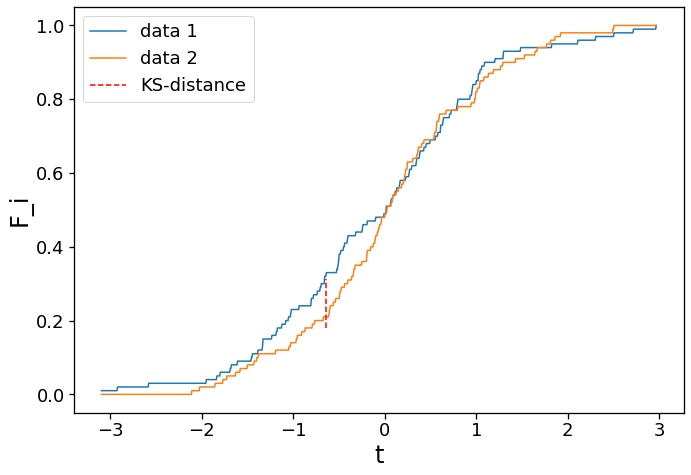

In [24]:
# let's visualize the result
# re-call the ks_stat() function
stat, stat_idx, x1, y1, x2, y2 = ks_stat(data1, data2, plot_data=True)

plt.plot(x1, y1, label='data 1')
plt.plot(x2, y2, label='data 2')
base = np.min([y1[stat_idx], y2[stat_idx]])
#top = np.max([y1[stat_idx], y2[stat_idx]])   # for checking the weird plotting artefact
plt.axvline(x=x1[stat_idx],  ymin=base, ymax=base+stat, color = 'r', linestyle='--', label='KS-distance')
plt.xlabel('t')
plt.ylabel('F_i')
plt.legend()
plt.show()

# note: overshoot of axvline is somehow a plotting artefact. 
# if you don't believe me, replace ymax=base+stat by ymax=top and you'll see